### Mapping the employment rate by state

##### Example with age 25-54 population

---

September 2, 2019

Brian Dew, @bd_econ

---

Example uses CPS microdata file from Census and a simplified shapefile of US state boundaries to show what share of each state's age 25-54 population is employed in a given month. 

In [1]:
month, year = 11, 2020

In [2]:
# Preliminaries and imports
%matplotlib inline
import datetime, os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize

date = datetime.date(year=year, month=month, day=1)
cpspath = '/home/brian/Documents/CPS/data/'
cps_pum_file = f'{date.strftime("%b%y").lower()}pub.dat'

age1, age2 = 25, 54

if os.path.isfile(cpspath + cps_pum_file) == False:
    print(f'Requires {cps_pum_file}. Download from Census.')
    
if os.path.isfile('shapefiles/states.shp') == False:
    print('Requires states.shp, states.dbf, states.shx. Download from GH.')

In [3]:
# Process CPS data
data = [{'fips': obs[92:94],
         'age': int(obs[121:123]),
         'mlr': int(obs[392:394]),
         'wgt': int(obs[612:622]) / 10_000}
       for obs in open(cpspath + cps_pum_file)
        if int(obs[612:622]) > 0]

state_ids = list(set([i['fips'] for i in data]))

# Calculate unemployment rate for age group
ages = range(age1, age2+1)
d = {}
for fips in state_ids:
    grp = sum([i['wgt'] for i in data if i['fips'] == fips 
               and i['mlr'] == 1 and i['age'] in ages])
    pop = sum([i['wgt'] for i in data if i['fips'] == fips
               and i['age'] in ages])
    d[fips] = grp / pop * 100

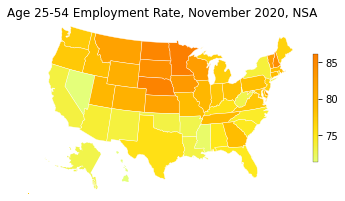

In [4]:
# Lower left and upper right lat/lon, projection, 
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

m.drawmapboundary()
m.readshapefile('shapefiles/states', 'states', drawbounds=False) 

ax = plt.gca()
ax.axis('off')
    
# Assign employment rate values to colors
cm = plt.cm.Wistia
norm = Normalize(min(d.values()), max(d.values()))

for info, shape in zip(m.states_info, m.states):
    ec = 'white'
    fc = cm(norm(d[info['STATE_FIPS']]))
    # Move and resize Hawaii and Alaska
    if info['STATE_NAME'] == 'Hawaii':
        shape = [(x + 5200000, y - 1400000) for x, y in shape]
        ec = None
    elif info['STATE_NAME'] == 'Alaska':
        shape = [(x*0.35 + 1100000, y*0.35 -1300000) for x, y in shape]
        ec = None
    fc = cm(norm(d[info['STATE_FIPS']]))
    ax.add_patch(Polygon(shape, fc=fc, ec=ec, lw=0.4))
    
plt.title(f'Age {age1}-{age2} Employment Rate, {date.strftime("%B %Y")}, NSA')
cb = plt.colorbar(ax.imshow([list(d.values())], cm), shrink=0.5)
cb.outline.set_linewidth(0.25)